In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci
import scipy.stats as scistats
from mcareader import Mca
import scipy.signal as fp
import os
import re

In [2]:
def extract_mca_data(file_path):
    data_values = []
    inside_data_section = False

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == "<<DATA>>":
                inside_data_section = True
                continue
            if line == "<<END>>":
                break
            if inside_data_section and line.isdigit():
                data_values.append(int(line))
    return data_values

In [3]:
directory = "team_battery"

# Regex to capture the float X from filenames like cal_10_(X).mca
pattern = re.compile(r"fe_\d+\_(\d*)\.mca")

# Temporary storage for (x_value, data_list)
temp_storage = []

for filename in os.listdir(directory):
    match = pattern.search(filename)
    if match:
        x_value = float(match.group(1))
        file_path = os.path.join(directory, filename)
        data = extract_mca_data(file_path)
        temp_storage.append((x_value, data))

# Sort by x_value
temp_storage.sort(key=lambda item: item[0])

# Separate into two lists
file_labels = [item[0] for item in temp_storage]
all_data_lists = [item[1] for item in temp_storage]

print(f"Loaded {len(all_data_lists)} files in ascending order of X.")
for i, data_list in enumerate(all_data_lists):
    print(f"File {i+1} (X={file_labels[i]}): {len(data_list)} points")

Loaded 22 files in ascending order of X.
File 1 (X=1388.0): 1024 points
File 2 (X=1448.0): 1024 points
File 3 (X=1508.0): 1024 points
File 4 (X=1568.0): 1024 points
File 5 (X=1568.0): 1024 points
File 6 (X=1628.0): 1024 points
File 7 (X=1688.0): 1024 points
File 8 (X=1748.0): 1024 points
File 9 (X=1748.0): 1024 points
File 10 (X=1808.0): 1024 points
File 11 (X=1868.0): 1024 points
File 12 (X=1928.0): 1024 points
File 13 (X=1928.0): 1024 points
File 14 (X=1988.0): 1024 points
File 15 (X=2048.0): 1024 points
File 16 (X=2048.0): 1024 points
File 17 (X=2108.0): 1024 points
File 18 (X=2168.0): 1024 points
File 19 (X=2168.0): 1024 points
File 20 (X=2228.0): 1024 points
File 21 (X=2288.0): 1024 points
File 22 (X=2348.0): 1024 points


In [4]:
bkg=extract_mca_data('team_battery/bkg_10_1789.mca')

In [5]:
index=21
minimum_expected_peak_height=4
minimum_bin_distance_between_peaks=100
minimum_peak_width=10
maximum_peak_width=200
minimum_peak_prominence=None
# threshold=13

channel_no=np.linspace(0,len(all_data_lists[index]),1024)

In [6]:
def gaussian(x, a, mu, sigma):
    return a*np.exp(-(x - mu)**2 / (2 * sigma**2))

In [7]:
def bkg_corrector(bkg_list,data_list,index):
    bkg_corr_data_list=[]
    for i in range(0,len(bkg_list)):
        bkg_corr_data=data_list[index][i]-bkg_list[i]
        bkg_corr_data_list.append(bkg_corr_data)
    bkg_corr_data_list=np.array(bkg_corr_data_list).clip(min=0)
    return bkg_corr_data_list

In [8]:
def peak_fitter(function, channel, data_list,fit_range,init_guess):
    mu, cov=sci.curve_fit(function,channel[fit_range[0]:fit_range[1]],data_list[fit_range[0]:fit_range[1]],p0=init_guess,maxfev=5000)
    gauss=gaussian(channel[fit_range[0]:fit_range[1]],*mu)
    channel_no_ranged=channel[fit_range[0]:fit_range[1]]
    return channel_no_ranged, gauss, mu, cov

In [9]:
def peak_scouter(index,minimum_expected_peak_height,minimum_bin_distance_between_peaks,minimum_peak_width,maximum_peak_width,minimum_peak_prominence,bkg,all_data_lists):
    peak_pnts=[]
    range_list=[]
    p0_list=[]
    bkg_corr_ind=bkg_corrector(bkg,all_data_lists,index)
    peaks, properties = fp.find_peaks(
        bkg_corr_ind,
        height=minimum_expected_peak_height,   # Filter noise, set to a value below expected peaks
        distance=minimum_bin_distance_between_peaks,  # To avoid detecting overlapping peaks
        width=(minimum_peak_width, maximum_peak_width),   # Accept variable peak widths
        prominence=minimum_peak_prominence,    # For sharper peaks, avoids flat humps
        rel_height=0.5
    )
    
    peak_bins = peaks
    peak_positions = channel_no[peak_bins]
    peak_width= properties["widths"]
    peak_heights=properties["peak_heights"]
    # print("Peak bins:", peak_bins)
    print("Rough peak positions:", peak_positions)
    print("NO. PEAKS DETECTED:", len(peak_positions))
    # print("Peak widths:", peak_width)
    print("Peak heights:", peak_heights)
    
    for i in peak_bins:
        peak_ind=bkg_corr_ind[i]
        peak_pnts.append(peak_ind)
        
    for i in range(0,len(peak_bins)):
        lower_lim=peak_bins[i]-peak_width[i]/2
        upper_lim=peak_bins[i]+peak_width[i]/2
        fit_range=[int(lower_lim+1),int(upper_lim+1)]
        range_list.append(fit_range)
        a_est=peak_heights[i]
        mu_est=peak_positions[i]
        sigma_est = peak_width[i]
        init_guess=[a_est,mu_est,sigma_est]
        p0_list.append(init_guess)
        # range.clear()
        
    # peak_pnts.clear()
    return peak_pnts,peak_bins,peak_positions,peak_width,range_list,p0_list,bkg_corr_ind

In [10]:

# def peak_scouter(index,minimum_expected_peak_height,minimum_bin_distance_between_peaks,minimum_peak_width,maximum_peak_width,minimum_peak_prominence,threshold_lvl,bkg,all_data_lists):
#     peak_pnts=[]
#     range_list=[]
#     p0_list=[]
#     bkg_corr_ind=bkg_corrector(bkg,all_data_lists,index)
#     peaks, properties = fp.find_peaks(
#         bkg_corr_ind,
#         height=minimum_expected_peak_height,   # Filter noise, set to a value below expected peaks
#         distance=minimum_bin_distance_between_peaks,  # To avoid detecting overlapping peaks
#         width=(minimum_peak_width, maximum_peak_width),   # Accept variable peak widths
#         prominence=minimum_peak_prominence,    # For sharper peaks, avoids flat humps
#         rel_height=0.5,
#         threshold=threshold_lvl
#     )
    
#     peak_bins = peaks
#     peak_positions = channel_no[peak_bins]
#     peak_width= properties["widths"]
#     peak_heights=properties["peak_heights"]
#     # print("Peak bins:", peak_bins)
#     print("Rough peak positions:", peak_positions)
#     print("NO. PEAKS DETECTED:", len(peak_positions))
#     # print("Peak widths:", peak_width)
#     print("Peak heights:", peak_heights)
    
#     for i in peak_bins:
#         peak_ind=bkg_corr_ind[i]
#         peak_pnts.append(peak_ind)
        
#     for i in range(0,len(peak_bins)):
#         lower_lim=peak_bins[i]-peak_width[i]/2
#         upper_lim=peak_bins[i]+peak_width[i]/2
#         fit_range=[int(lower_lim+1),int(upper_lim+1)]
#         range_list.append(fit_range)
#         a_est=peak_heights[i]
#         mu_est=peak_positions[i]
#         sigma_est = peak_width[i]
#         init_guess=[a_est,mu_est,sigma_est]
#         p0_list.append(init_guess)
#         # range.clear()
        
#     # peak_pnts.clear()
#     return peak_pnts,peak_bins,peak_positions,peak_width,range_list,p0_list,bkg_corr_ind

In [11]:
def graphfitter(range_list,function,channels,bkg_corr_data,p0_list):
    ranged_channel_list=[]
    fit_gauss_list=[]
    for peaks in range(0,len(range_list)):
        ranged_channel,fit_gauss,mu,cov  = peak_fitter(function,channels,bkg_corr_data,range_list[peaks],p0_list[peaks])
        ranged_channel_list.append(ranged_channel)
        fit_gauss_list.append(fit_gauss)
        centroid_error=np.sqrt(np.diag(cov))
        print(f"The fitting range for peak {peaks}:",ranged_channel[0],ranged_channel[-1])
        print(f"The centroid for peak {peaks}:",mu[1])
        print(f"The error on the centroid fit for peak {peaks}:", centroid_error[1])
    return ranged_channel_list, fit_gauss_list

In [12]:
# peak_pnts, peak_bins, peak_positions, peak_width, range_list, p0_list, bkg_corr_ind  =  peak_scouter(index,minimum_expected_peak_height,minimum_bin_distance_between_peaks,minimum_peak_width,maximum_peak_width,minimum_peak_prominence,threshold,bkg,all_data_lists)

In [13]:
peak_pnts, peak_bins, peak_positions, peak_width, range_list, p0_list, bkg_corr_ind  =  peak_scouter(index,minimum_expected_peak_height,minimum_bin_distance_between_peaks,minimum_peak_width,maximum_peak_width,minimum_peak_prominence,bkg,all_data_lists)

Rough peak positions: [787.76930596]
NO. PEAKS DETECTED: 1
Peak heights: [46.]


In [14]:
print(peak_width)

[19.7375]


In [15]:
ranged_channel_list,fit_gauss_list = graphfitter(range_list,gaussian,channel_no,bkg_corr_ind,p0_list)

The fitting range for peak 0: 778.7605083088954 796.7781036168133
The centroid for peak 0: 2673.4607712607417
The error on the centroid fit for peak 0: 1803225.4428019866


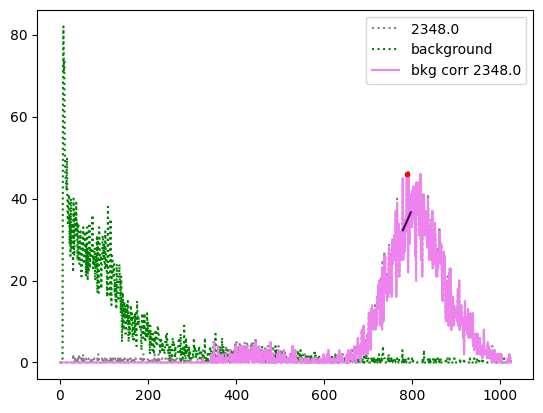

Initial guess list [[np.float64(46.0), np.float64(787.7693059628543), np.float64(19.737499999999955)]]
Fitting range for each peak [[778, 797]]


In [16]:
#plotting the curve and the peaks (Still working on the automatic fitting, worst case scenario we can just manually fit the curves)
peakcolors=len(ranged_channel_list)
peaklegend=plt.cm.PRGn(np.linspace(0,1,peakcolors))
fig, ax = plt.subplots()
ax.plot(channel_no,all_data_lists[index],label=file_labels[index],color='grey',linestyle='dotted')
ax.plot(channel_no,bkg,label='background',color='green',linestyle='dotted')
ax.plot(channel_no,bkg_corr_ind,label=f'bkg corr {file_labels[index]}',color='violet')
ax.plot(peak_positions,peak_pnts,'r.')
for fitpeak in range(0,len(ranged_channel_list)):
    ax.plot(ranged_channel_list[fitpeak],fit_gauss_list[fitpeak],color=peaklegend[fitpeak])
ax.legend()
# plt.xlim(0,200)
plt.show()
print("Initial guess list",p0_list)
print("Fitting range for each peak",range_list)




In [17]:
# for bias_voltage in range(0,len(all_data_lists)):
#     print("BIAS VOLTAGE",file_labels[bias_voltage],": Index",bias_voltage)
#     peak_pnts, peak_bins, peak_positions, peak_width, range_list, p0_list,bkg_corr_ind  =  peak_scouter(bias_voltage,minimum_expected_peak_height,minimum_bin_distance_between_peaks,minimum_peak_width,maximum_peak_width,minimum_peak_prominence,threshold,bkg,all_data_lists)
#     # graphfitter(range_list,gaussian,channel_no,bkg_corr_ind,p0_list)
    

In [18]:
for bias_voltage in range(0,len(all_data_lists)):
    print("BIAS VOLTAGE",file_labels[bias_voltage],": Index",bias_voltage)
    peak_pnts, peak_bins, peak_positions, peak_width, range_list, p0_list,bkg_corr_ind  =  peak_scouter(bias_voltage,minimum_expected_peak_height,minimum_bin_distance_between_peaks,minimum_peak_width,maximum_peak_width,minimum_peak_prominence,bkg,all_data_lists)
    # graphfitter(range_list,gaussian,channel_no,bkg_corr_ind,p0_list)

BIAS VOLTAGE 1388.0 : Index 0
Rough peak positions: [46.04496579]
NO. PEAKS DETECTED: 1
Peak heights: [305.]
BIAS VOLTAGE 1448.0 : Index 1
Rough peak positions: [65.06353861]
NO. PEAKS DETECTED: 1
Peak heights: [289.]
BIAS VOLTAGE 1508.0 : Index 2
Rough peak positions: [96.09384164]
NO. PEAKS DETECTED: 1
Peak heights: [218.]
BIAS VOLTAGE 1568.0 : Index 3
Rough peak positions: [132.12903226]
NO. PEAKS DETECTED: 1
Peak heights: [185.]
BIAS VOLTAGE 1568.0 : Index 4
Rough peak positions: []
NO. PEAKS DETECTED: 0
Peak heights: []
BIAS VOLTAGE 1628.0 : Index 5
Rough peak positions: [81.07917889]
NO. PEAKS DETECTED: 1
Peak heights: [331.]
BIAS VOLTAGE 1688.0 : Index 6
Rough peak positions: [123.1202346]
NO. PEAKS DETECTED: 1
Peak heights: [253.]
BIAS VOLTAGE 1748.0 : Index 7
Rough peak positions: [93.09090909]
NO. PEAKS DETECTED: 1
Peak heights: [304.]
BIAS VOLTAGE 1748.0 : Index 8
Rough peak positions: [184.17986315]
NO. PEAKS DETECTED: 1
Peak heights: [157.]
BIAS VOLTAGE 1808.0 : Index 9
Ro

In [19]:
numline=len(all_data_lists)
colour=plt.cm.plasma(np.linspace(0,1,numline))

In [20]:
def hist_generator_bkg_corrected(index,data_list,bkg,label_list,color):
    bkg_correction=bkg_corrector(bkg,data_list,index)
    # plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])
    plt.plot(np.linspace(0,len(data_list[index]),1024),bkg_correction,label=f"corrected {label_list[index]}",color=color)
    # plt.xlim(0,100)
    plt.axline([0,30],slope=0,color='black',linestyle='dashed',linewidth=0.7)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))


In [21]:
def hist_generator(index,data_list,label_list,color):
    plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index],color=color)
    plt.axline([0,30],slope=0,color='black',linestyle='dashed',linewidth=0.7)
    # plt.xlim(0,100)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))

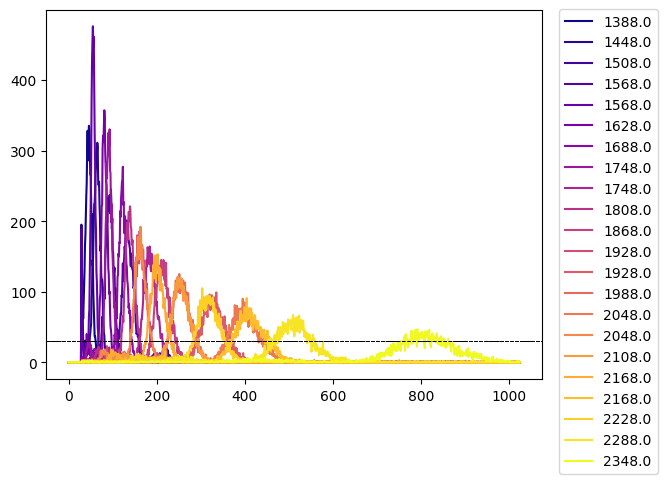

In [22]:
for i in range(0,len(all_data_lists)):
    hist_generator(i,all_data_lists,file_labels,colour[i])

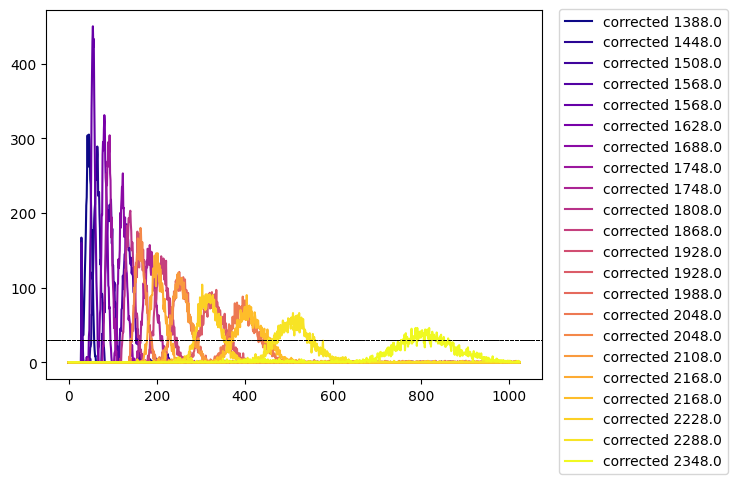

In [23]:
for i in range(0,len(all_data_lists)):
    hist_generator_bkg_corrected(i,all_data_lists,bkg,file_labels,colour[i])
    